## Ejercicio final de curso Machine Learning para imágenes geoespaciales.

El objetivo de este ejercicio es repasar los conceptos que vimos de segmentación semántica, a partir de un dataset de cuerpos de agua en imágenes Sentinel-2 (RGB).

Fuente del dataset: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies



In [1]:
# estandar
import os
import cv2 as cv
from keras.metrics import MeanIoU
from tqdm import tqdm

# data
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

# viz
import matplotlib.pyplot as plt

# modelo
import keras
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Input, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **Data**

Esta función nos va a ayudar a mostrar las imágenes.

In [2]:
def show_image(image, cmap=None, title=None):
  plt.imshow(image, cmap=cmap)
  if title is not None: plt.title(title)
  plt.axis('off')


Levantamos los datos desde Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Traemos los datos desde Google Drive y los guardamos en el directorio de `data`.

In [4]:
!mkdir -p data/
# !unzip -qq /content/drive/MyDrive/ml_tp/archive.zip -d data/
!cp -r "/content/drive/MyDrive/Water Bodies Dataset" data/


In [ ]:
!ls "data/Water Bodies Dataset" | head -20

Images
Masks


In [5]:
import os
images = []
mask = []

image_path = 'data/Water Bodies Dataset/Images/'
mask_path = 'data/Water Bodies Dataset/Masks/'

image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

if image_names == mask_names:
  print('Imagenes y máscaras correctamente localizadas')

Imagenes y máscaras correctamente localizadas


In [6]:
SIZE = 128
images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
  path = image_path + image_names[id]
  img = img_to_array(load_img(path)).astype('float')/255.
  img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
  images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
  path = mask_path + mask_names[id]
  mask = img_to_array(load_img(path)).astype('float')
  mask = mask/255.
  mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
  masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [00:39<00:00, 71.17it/s] 


Vemos un ejemplo del conjunto de imágenes.

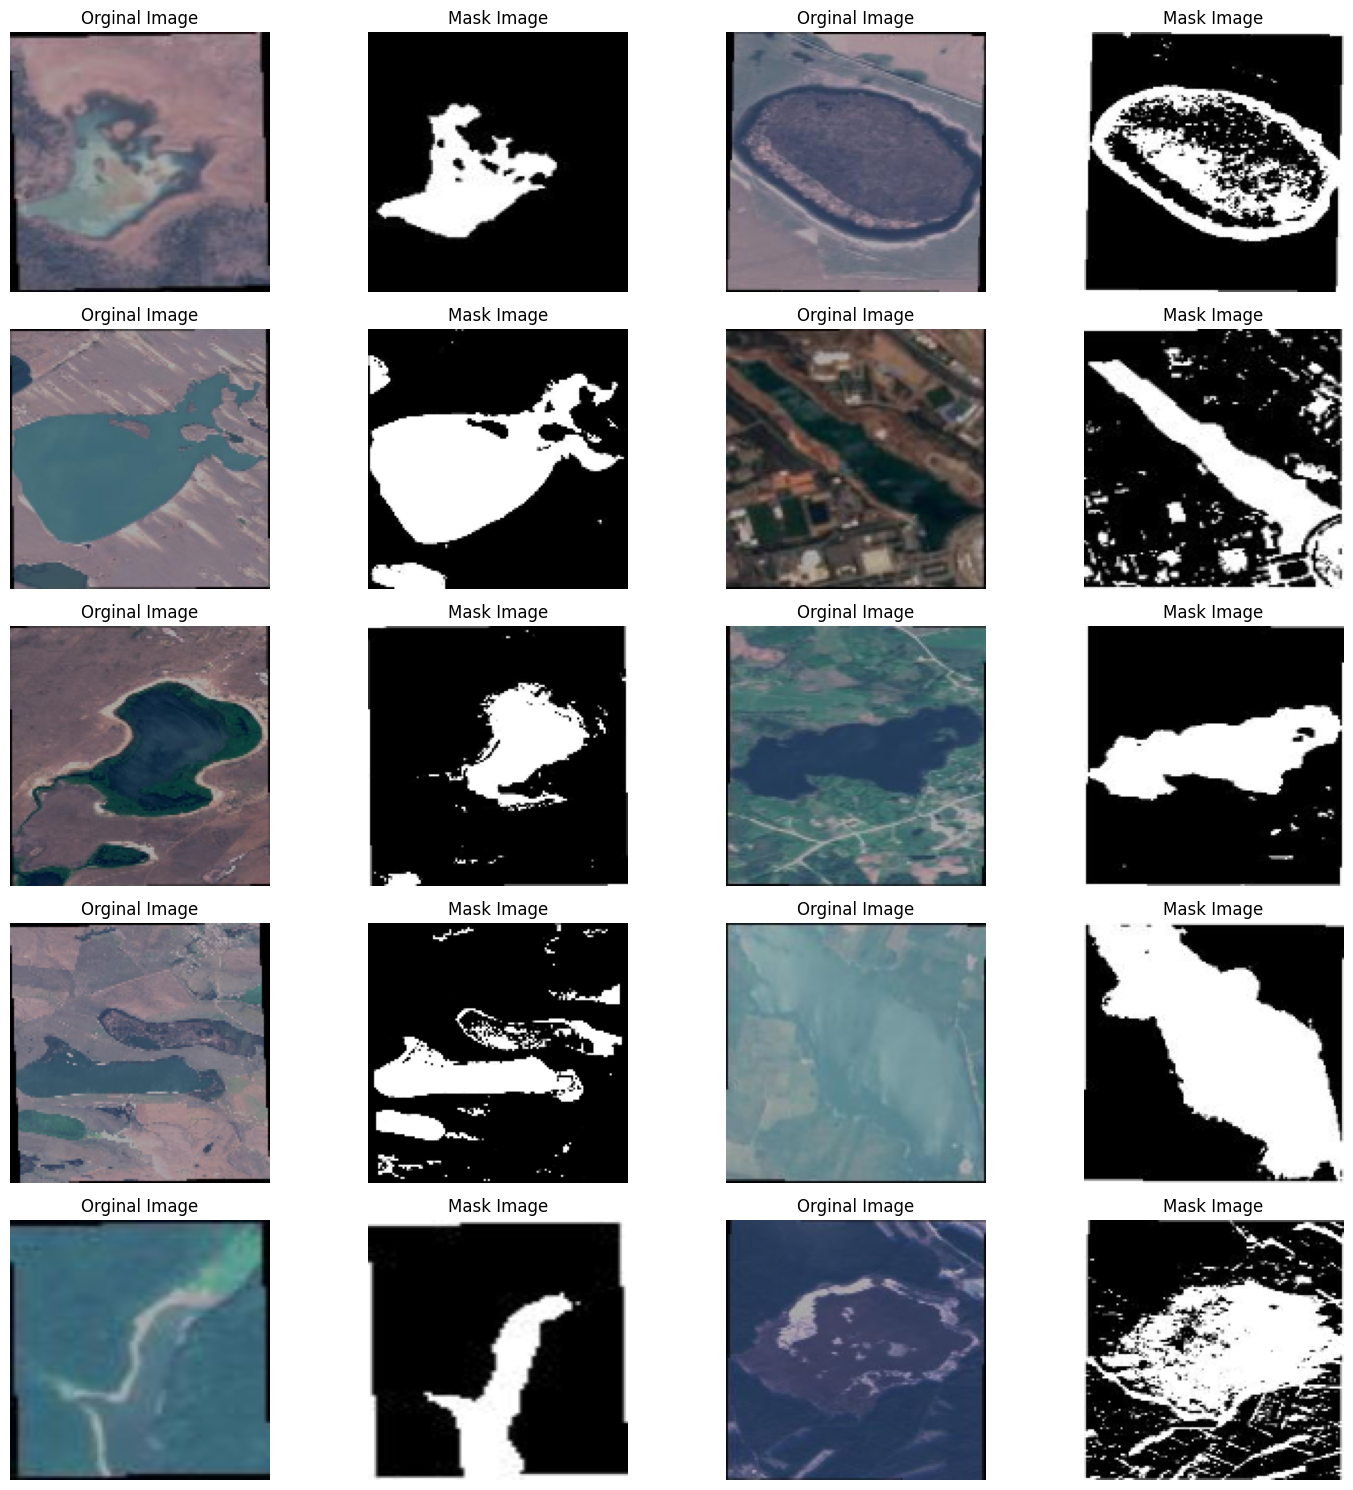

In [ ]:
plt.figure(figsize=(15,15))
for i in range(1,21):
  plt.subplot(5,4,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    show_image(images[id], title="Orginal Image")
  elif i%2==0:
    show_image(masks[id].reshape(128,128), title="Mask Image", cmap='gray')

plt.tight_layout()
plt.show()

# **U-Net**

Ejercicio 1: separar el dataset en entrenamiento y predicción.

Llamar `X` e `y` al conjunto de datos de imágenes y máscaras respectivamente.

In [ ]:
total_size = len(images)

train_size = int(total_size * 0.7)
val_size = int(total_size * 0.2)

X_train, y_train = images[:train_size], masks[:train_size]
X_val, y_val = images[train_size:train_size + val_size], masks[train_size:train_size + val_size]
X_test, y_test = images[train_size + val_size:], masks[train_size + val_size:]

## Aumento de datos

In [ ]:
import albumentations as A
import numpy as np

def augment_image(image, mask):

    # Asegurarse de que ambas tengan el mismo tipo de datos
    image = image.astype(np.uint8)
    mask = mask.astype(np.uint8)


    transform = A.Compose([
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5)
    ])

    augmented = transform(image=image, mask=mask)
    image_aug = augmented['image']
    mask_aug = augmented['mask']

    return image_aug, mask_aug


X_train_aug = []
y_train_aug = []

for img, msk in zip(X_train, y_train):

    img_aug, msk_aug = augment_image(img, msk)
    X_train_aug.append(img_aug)
    y_train_aug.append(msk_aug)

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

X_train_final = np.concatenate([X_train, X_train_aug], axis=0)
y_train_final = np.concatenate([y_train, y_train_aug], axis=0)


Asignar de esta manera:

* X_train, y_train: 70% de los datos

* X_val, y_val: 20%

* X_test, y_test: 10%

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Activation
from tensorflow.keras.optimizers import Adam

def conv_block(input_tensor, num_filters):
    """Construye un bloque de convolución con dos capas convolucionales con ReLU."""
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    return x

def encoder_block(input_tensor, num_filters):
    """Construye un bloque codificador que incluye un bloque de convolución seguido de una capa de max pooling."""
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """Construye un bloque decodificador que incluye una capa de upsampling, concatenación y un bloque de convolución."""
    x = UpSampling2D((2, 2))(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

def unet(input_size=(160, 160, 1), num_classes=1):
    inputs = Input(input_size)

    # Encoder
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    # Salida
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid' if num_classes == 1 else 'softmax')(d4)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Definir el tamaño de entrada de la U-Net
input_shape = (128, 128, 3)  # Ajustar al tamaño de tus imágenes

# Crear el modelo U-Net
unet_model = unet(input_shape)
unet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 32, 32, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 16, 16, 512)    │              0 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(X_train_final.shape, y_train_final.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3976, 128, 128, 3) (3976, 128, 128, 1)
(568, 128, 128, 3) (568, 128, 128, 1)
(285, 128, 128, 3) (285, 128, 128, 1)


Ejercicio 4:

Crear una función llamada `unet` que reciba como parametros de entrada el tamaño de las imagenes de entrada (una tupla) y la cantidad de clase a predecir.

Por ejemplo:
`def unet(input_size=(160, 160, 1), num_classes=1):`

Contemplar el tamaño de las imágenes de entrada.

In [ ]:
unet = unet_model

unet.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

Agregamos una clase para mostrar visualmente el progreso cuando entrenamos la red. Vamos a ver esto reflejado en los Callbacks.

In [ ]:
# Callback
class ShowProgress(keras.callbacks.Callback):
  def __init__(self, save=False):
    self.save = save
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(images))
    real_img = images[id][np.newaxis,...]
    pred_mask = self.model.predict(real_img).reshape(128,128)
    proc_mask1 = post_process(pred_mask)
    proc_mask2 = post_process(pred_mask, threshold=0.5)
    proc_mask3 = post_process(pred_mask, threshold=0.9)
    mask = masks[id].reshape(128,128)

    plt.figure(figsize=(10,5))

    plt.subplot(1,6,1)
    show_image(real_img[0], title="Orginal Image")

    plt.subplot(1,6,2)
    show_image(pred_mask, title="Predicted Mask", cmap='gray')

    plt.subplot(1,6,3)
    show_image(mask, title="Orginal Mask", cmap='gray')

    plt.subplot(1,6,4)
    show_image(proc_mask1, title="Processed@0.4", cmap='gray')

    plt.subplot(1,6,5)
    show_image(proc_mask2, title="Processed@0.5", cmap='gray')

    plt.subplot(1,6,6)
    show_image(proc_mask3, title="Processed@0.9", cmap='gray')

    plt.tight_layout()
    if self.save: plt.savefig("Progress-{}.png".format(epoch+1))
    plt.show()

# Post Process
def post_process(image,threshold=0.4):
  return image>threshold


In [ ]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('UNet-01.keras', save_best_only=True),
    ShowProgress(save=True)
]

Ejercicio 5:

Entrenar la red, con un batch_size de 16, 30 epochs y usando X_val e y_val como datos de validación.

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


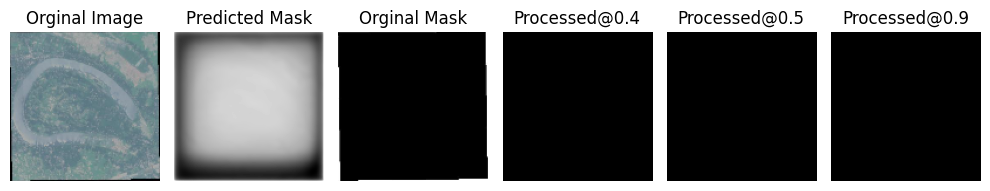

249/249 ━━━━━━━━━━━━━━━━━━━━ 152s 453ms/step - accuracy: 0.6468 - loss: 0.6942 - val_accuracy: 0.5460 - val_loss: 0.5770
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


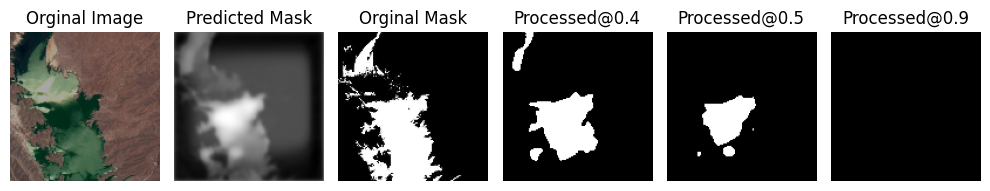

249/249 ━━━━━━━━━━━━━━━━━━━━ 120s 254ms/step - accuracy: 0.6560 - loss: 0.5712 - val_accuracy: 0.5500 - val_loss: 0.5562
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


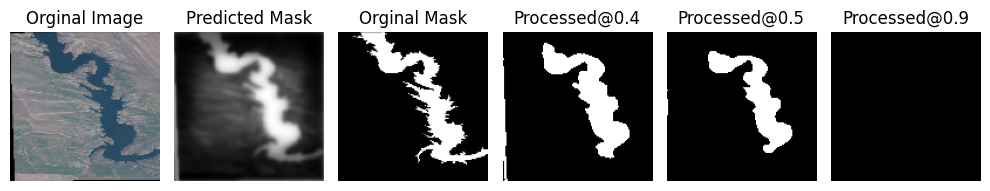

249/249 ━━━━━━━━━━━━━━━━━━━━ 72s 291ms/step - accuracy: 0.6830 - loss: 0.5460 - val_accuracy: 0.5825 - val_loss: 0.5086
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


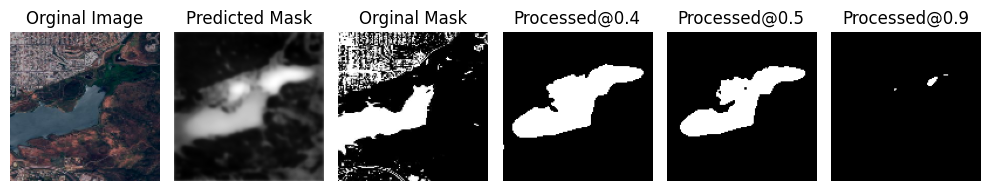

249/249 ━━━━━━━━━━━━━━━━━━━━ 80s 321ms/step - accuracy: 0.6882 - loss: 0.5281 - val_accuracy: 0.5994 - val_loss: 0.4750
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


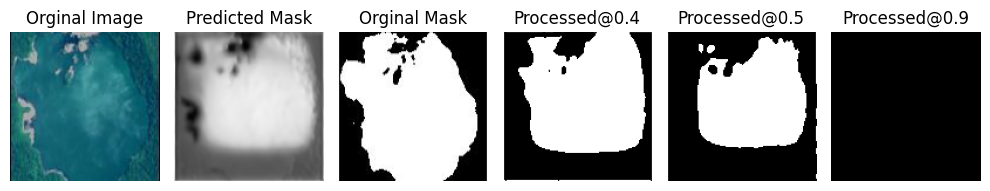

249/249 ━━━━━━━━━━━━━━━━━━━━ 56s 226ms/step - accuracy: 0.6951 - loss: 0.5117 - val_accuracy: 0.5891 - val_loss: 0.5030
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


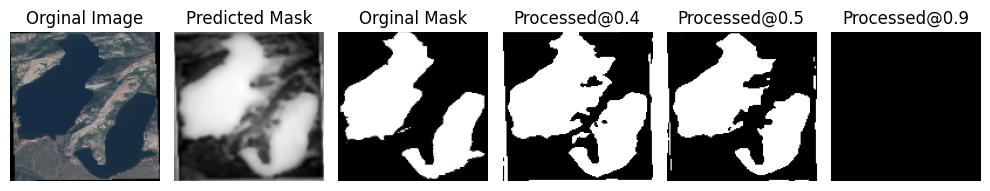

249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 226ms/step - accuracy: 0.6911 - loss: 0.5184 - val_accuracy: 0.5764 - val_loss: 0.4847
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


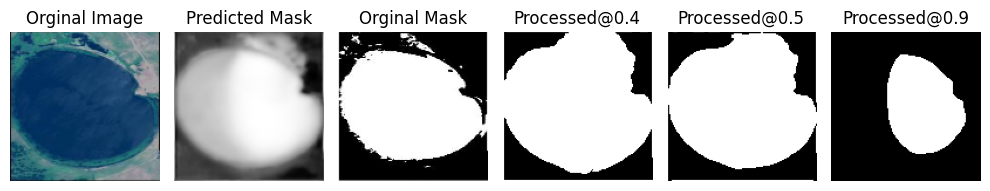

249/249 ━━━━━━━━━━━━━━━━━━━━ 103s 312ms/step - accuracy: 0.6965 - loss: 0.5121 - val_accuracy: 0.6178 - val_loss: 0.4303
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


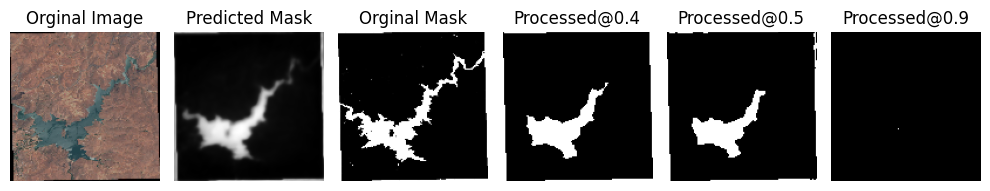

249/249 ━━━━━━━━━━━━━━━━━━━━ 92s 353ms/step - accuracy: 0.7086 - loss: 0.4999 - val_accuracy: 0.6273 - val_loss: 0.4301
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


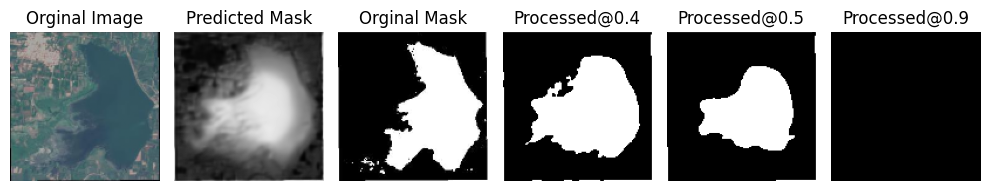

249/249 ━━━━━━━━━━━━━━━━━━━━ 142s 353ms/step - accuracy: 0.7097 - loss: 0.4899 - val_accuracy: 0.6432 - val_loss: 0.4039
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


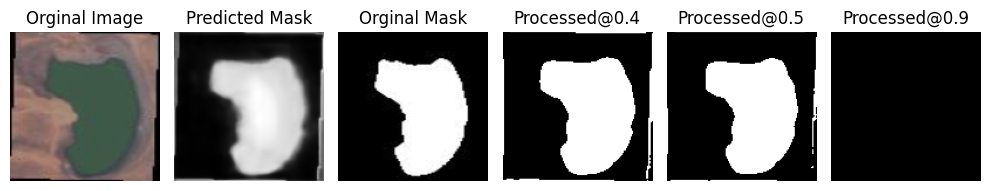

249/249 ━━━━━━━━━━━━━━━━━━━━ 110s 225ms/step - accuracy: 0.7175 - loss: 0.4764 - val_accuracy: 0.6238 - val_loss: 0.4337
Epoch 11/30


In [ ]:
batch_size = 16
epochs = 30

history = unet_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks
)


Ejercicio 6: imprimir tres ejemplos al azar de la predicción del modelo y la máscara de verdad de campo asociada, a fines de evaluar cualitativamente el modelo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_examples(model, images, masks, num_examples=3, threshold=0.5):

    indices = np.random.choice(len(images), num_examples, replace=False)

    plt.figure(figsize=(10, 5 * num_examples))

    for i, idx in enumerate(indices):

        img = images[idx][np.newaxis, ...]
        true_mask = masks[idx]

        pred_mask = model.predict(img).reshape(img.shape[1], img.shape[2])
        pred_mask_binary = pred_mask > threshold

        plt.subplot(num_examples, 3, i * 3 + 1)
        plt.imshow(img[0], cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        # Mostrar la máscara real
        plt.subplot(num_examples, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        # Mostrar la máscara predicha
        plt.subplot(num_examples, 3, i * 3 + 3)
        plt.imshow(pred_mask_binary, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_examples(unet_model, X_val, y_val, num_examples=3, threshold=0.5)


Ejercicio 7:

Aplicar el modelo al conjunto de datos de test (X_test) y comparar con y_test, eligiendo una métrica acorde al problema (como IoU). Reportar esa métrica

In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

def calculate_iou(y_true, y_pred, threshold=0.5):

    # Aplanar las máscaras para compararlas píxel a píxel
    y_true_flat = y_true.reshape(-1).astype(int)
    y_pred_flat = (y_pred.reshape(-1) > threshold).astype(int)

    iou = jaccard_score(y_true_flat, y_pred_flat, average='binary')
    return iou


y_pred_test = unet_model.predict(X_test)
iou_score = calculate_iou(y_test, y_pred_test, threshold=0.5)
print(f"IoU Score on Test Set: {iou_score:.4f}")


def calculate_f1(y_true, y_pred, threshold=0.5):

    # Aplanar las máscaras para compararlas píxel a píxel
    y_true_flat = y_true.reshape(-1).astype(int)
    y_pred_flat = (y_pred.reshape(-1) > threshold).astype(int)

    f1 = f1_score(y_true_flat, y_pred_flat, average='binary')
    return f1

f1_score_test = calculate_f1(y_test, y_pred_test, threshold=0.5)
print(f"F1 Score on Test Set: {f1_score_test:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
IoU Score on Test Set: 0.5051
F1 Score on Test Set: 0.6712


In [7]:
!pip install segment-geospatial


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.1/489.1 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 408.3

Ejercicio 8:

Segmentar todas las imágenes usando Segment Anything de Meta, derivar las máscaras y volver a calcular la métrica del ejercicio 7.

In [ ]:
import os
import numpy as np
import cv2 as cv
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from samgeo import SamGeo

SIZE = 128

image_path = 'data/Water Bodies Dataset/Images/'
image_names = sorted(next(os.walk(image_path))[-1])

images = np.zeros(shape=(len(image_names), SIZE, SIZE, 3))

for id in tqdm(range(len(image_names)), desc="Cargando Imágenes"):
    path = os.path.join(image_path, image_names[id])
    img = img_to_array(load_img(path)).astype('float32') / 255.0
    img = cv.resize(img, (SIZE, SIZE), cv.INTER_AREA)
    images[id] = img

sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    sam_kwargs=None,
)

sam_generated_masks = []

for id in tqdm(range(len(images)), desc="Generando Máscaras de Segmentación con SAM"):

    # Guardar la imagen actual en un archivo temporal (SAM trabaja con archivos)
    temp_image_path = "/content/temp_image.tif"
    cv.imwrite(temp_image_path, (images[id] * 255).astype(np.uint8))

    # Definir el nombre del archivo de máscara de salida
    temp_mask_path = "/content/temp_mask.tif"

    # Generar la máscara utilizando SAM sin ningún text prompt
    sam.generate(
        source=temp_image_path,
        output=temp_mask_path,
        batch=True,
        foreground=False,
        erosion_kernel=(3, 3),
        mask_multiplier=255,
    )

    sam_mask = cv.imread(temp_mask_path, cv.IMREAD_GRAYSCALE).astype('float32') / 255.0
    sam_mask_resized = cv.resize(sam_mask, (SIZE, SIZE), cv.INTER_AREA)

    sam_generated_masks.append(sam_mask_resized)

    # Eliminar los archivos temporales para liberar espacio
    os.remove(temp_image_path)
    os.remove(temp_mask_path)

# Convertir la lista de máscaras generadas a un array numpy
sam_generated_masks = np.array(sam_generated_masks)[:, :, :, np.newaxis]


  0%|          | 0/1 [00:00<?, ?it/s]

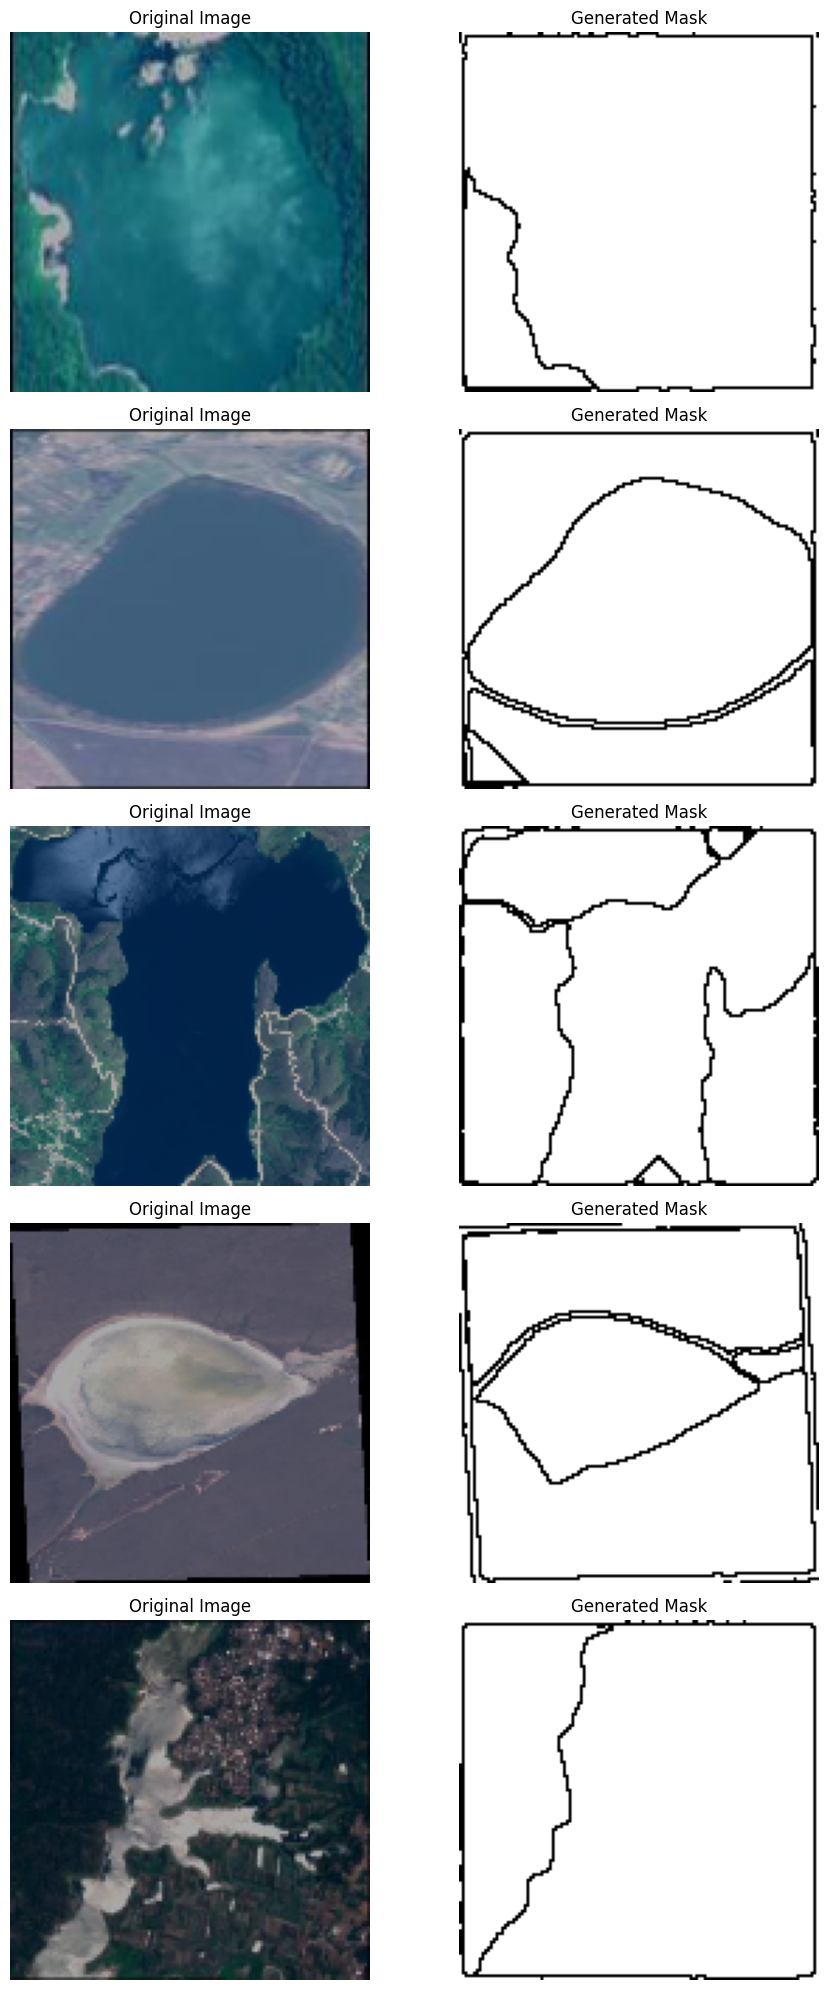

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_generated_masks(images, masks, num_examples=5):

    plt.figure(figsize=(10, 4 * num_examples))
    indices = np.random.choice(len(masks), num_examples, replace=False)

    for i, idx in enumerate(indices):
        # Imagen original
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(images[idx])
        plt.title("Original Image")
        plt.axis('off')

        # Máscara generada
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(masks[idx].squeeze(), cmap='gray')
        plt.title("Generated Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


visualize_generated_masks(images[:10], sam_generated_masks[:10], num_examples=5)